In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path ='/content/drive/MyDrive/Cloud_Security_Project/'
data_path = base_path + "10_food_classes_all_data/"
model_path = base_path + 'resnet_trained_model_classification'

In [ ]:
train_dir = data_path+"train/"
test_dir =  data_path+"test/"

In [ ]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
import os
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, AveragePooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Image shape: (384, 512, 3)


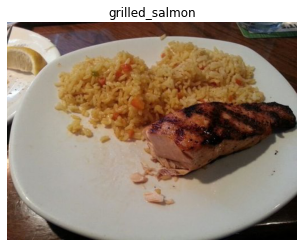

In [ ]:

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img


# View a random image from the training dataset

img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name

In [ ]:


# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

print('image processing  done')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
image processing  done


# Load trained Model for classification

In [ ]:
model = tf.keras.models.load_model(model_path)

In [ ]:
model.fit(train_data,
          epochs=5,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=len(test_data),
        )

Epoch 1/5
235/235 [==============================] - 2426s 10s/step - loss: 0.6520 - accuracy: 0.7863 - val_loss: 0.5026 - val_accuracy: 0.8292
Epoch 2/5
235/235 [==============================] - 1676s 7s/step - loss: 0.4806 - accuracy: 0.8447 - val_loss: 0.4882 - val_accuracy: 0.8380
Epoch 3/5
235/235 [==============================] - 1663s 7s/step - loss: 0.3926 - accuracy: 0.8732 - val_loss: 0.4713 - val_accuracy: 0.8416
Epoch 4/5
235/235 [==============================] - 1668s 7s/step - loss: 0.3357 - accuracy: 0.8920 - val_loss: 0.4670 - val_accuracy: 0.8488
Epoch 5/5
235/235 [==============================] - 1665s 7s/step - loss: 0.2907 - accuracy: 0.9113 - val_loss: 0.4704 - val_accuracy: 0.8500


In [ ]:
model.evaluate(test_data)

79/79 [==============================] - 430s 5s/step - loss: 0.4704 - accuracy: 0.8500


[0.4703679084777832, 0.8500000238418579]

# Now testing with noisy data

In [ ]:
noisy_test_dir =  data_path+"test_noisy_data/"

In [ ]:
n_test_data = train_datagen.flow_from_directory(noisy_test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 1881 images belonging to 10 classes.


In [ ]:
model.evaluate(n_test_data)

59/59 [==============================] - 679s 12s/step - loss: 0.8060 - accuracy: 0.7475


[0.8060296177864075, 0.747474730014801]

# Model set up

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes=10)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
resnet_model.fit(train_data,
          epochs=5,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=len(test_data),
        )

Epoch 1/5
235/235 [==============================] - 2271s 10s/step - loss: 0.9108 - accuracy: 0.7005 - val_loss: 0.5304 - val_accuracy: 0.8268
Epoch 2/5
235/235 [==============================] - 1770s 8s/step - loss: 0.5354 - accuracy: 0.8248 - val_loss: 0.4798 - val_accuracy: 0.8400
Epoch 3/5
235/235 [==============================] - 1769s 8s/step - loss: 0.4308 - accuracy: 0.8584 - val_loss: 0.4604 - val_accuracy: 0.8464
Epoch 4/5
 78/235 [========>.....................] - ETA: 14:58 - loss: 0.3396 - accuracy: 0.8974

KeyboardInterrupt: ignored